# External Validation of DDI Model using TWOSIDES

Objective:
To externally validate a pretrained GNN-based Drug–Drug Interaction (DDI) model
using real-world pharmacovigilance signals from the TWOSIDES dataset.

Key Ideas:
- GNN is the primary mechanistic predictor
- XGBoost acts as an independent auditor
- TWOSIDES provides real-world evidence (PRR, reporting frequency)


In [8]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import joblib
import requests
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATv2Conv, global_mean_pool, global_max_pool, LayerNorm

from rdkit import Chem
from rdkit.Chem import rdchem, AllChem


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [10]:
class MedicalGNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = GATv2Conv(8, 128, heads=4, edge_dim=3)
        self.n1 = LayerNorm(512)
        self.c2 = GATv2Conv(512, 128, heads=2, edge_dim=3)
        self.n2 = LayerNorm(256)
        self.c3 = GATv2Conv(256, 128, heads=1, edge_dim=3)
        self.n3 = LayerNorm(128)
        self.dp = nn.Dropout(0.25)

    def forward(self, g):
        x, ei, ea, b = g.x, g.edge_index, g.edge_attr, g.batch
        x = self.dp(F.elu(self.n1(self.c1(x, ei, ea))))
        x = self.dp(F.elu(self.n2(self.c2(x, ei, ea))))
        x = F.elu(self.n3(self.c3(x, ei, ea)))
        return torch.cat(
            [global_mean_pool(x, b), global_max_pool(x, b)],
            dim=1
        )


class SiameseDDI(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.enc = MedicalGNNEncoder()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, g1, g2):
        return self.fc(torch.cat([self.enc(g1), self.enc(g2)], dim=1))


In [11]:
def get_atom_features(atom):
    hyb = {
        rdchem.HybridizationType.SP: 0,
        rdchem.HybridizationType.SP2: 1,
        rdchem.HybridizationType.SP3: 2,
        rdchem.HybridizationType.SP3D: 3,
        rdchem.HybridizationType.SP3D2: 4,
    }
    return [
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        hyb.get(atom.GetHybridization(), 5),
        int(atom.GetIsAromatic()),
        atom.GetFormalCharge(),
        int(atom.IsInRing()),
        atom.GetNumRadicalElectrons(),
        int(atom.GetChiralTag())
    ]


def get_bond_features(bond):
    bt = {
        rdchem.BondType.SINGLE: 0,
        rdchem.BondType.DOUBLE: 1,
        rdchem.BondType.TRIPLE: 2,
        rdchem.BondType.AROMATIC: 3,
    }
    return [
        bt.get(bond.GetBondType(), 4),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing())
    ]


def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(str(smiles))
    if mol is None:
        return None

    x = torch.tensor(
        [get_atom_features(a) for a in mol.GetAtoms()],
        dtype=torch.float
    )

    edge_index, edge_attr = [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        f = get_bond_features(b)
        edge_attr += [f, f]

    if len(edge_index) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 3), dtype=torch.float)
    else:
        edge_index = torch.tensor(edge_index).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


In [12]:
with open("ddi_metadata.json", "r") as f:
    meta = json.load(f)

NUM_CLASSES = len(meta["label_map"])

model = SiameseDDI(NUM_CLASSES).to(device)
model.load_state_dict(torch.load("best_ddi_model.pt", map_location=device))
model.eval()

auditor = joblib.load("auditor_xgboost.pkl")

final_desc_map = {int(k): v for k, v in meta["description_map"].items()}
class_freq = {int(k): float(v) for k, v in meta["class_freq"].items()}

print("All assets loaded successfully")


All assets loaded successfully


In [13]:
chunks = pd.read_csv(
    "twosides.csv",
    chunksize=200_000,
    low_memory=False
)

rows = []

for chunk in tqdm(chunks):
    chunk["PRR"] = pd.to_numeric(chunk["PRR"], errors="coerce")
    chunk["mean_reporting_frequency"] = pd.to_numeric(
        chunk["mean_reporting_frequency"], errors="coerce"
    )

    chunk = chunk.dropna(subset=["PRR", "mean_reporting_frequency"])
    chunk = chunk[(chunk["PRR"] > 2) & (chunk["mean_reporting_frequency"] > 0.05)]

    rows.append(chunk)

twoside_df = pd.concat(rows, ignore_index=True)
print("High-confidence TWOSIDES rows:", len(twoside_df))


215it [01:49,  1.96it/s]


High-confidence TWOSIDES rows: 4439304


In [22]:
print(twoside_df.columns.tolist())
twoside_df.head(3)


['drug_1_rxnorn_id', 'drug_1_concept_name', 'drug_2_rxnorm_id', 'drug_2_concept_name', 'condition_meddra_id', 'condition_concept_name', 'A', 'B', 'C', 'D', 'PRR', 'PRR_error', 'mean_reporting_frequency']


,drug_1_rxnorn_id,drug_1_concept_name,drug_2_rxnorm_id,drug_2_concept_name,condition_meddra_id,condition_concept_name,A,B,C,D,PRR,PRR_error,mean_reporting_frequency
0,1808,Bumetanide,7824,Oxytocin,10003239,Arthralgia,1,13,2,138,5.00000,1.19224,0.071429
1,221147,POLYETHYLENE GLYCOL 3350,5521,Hydroxychloroquine,10003239,Arthralgia,6,103,20,1070,3.00000,0.454505,0.055046
2,10324,Tamoxifen,8640,Prednisone,10012735,Diarrhoea,18,123,35,1375,5.14286,0.276271,0.127660


In [47]:
MAX_LOOP_ROWS = 10_000        
TARGET_SUCCESS = 5_000        
MC_RUNS = 3                  
API_SLEEP = 0.12              


In [48]:
from collections import Counter

STATS = Counter(
    scanned=0,
    success=0,
    cache_hit=0,
    api_hit=0,
    failed=0,
    invalid_smiles=0
)


In [49]:
def run_model(smiles1, smiles2):
    g1 = smiles_to_graph(smiles1)
    g2 = smiles_to_graph(smiles2)
    if g1 is None or g2 is None:
        return None

    b1 = Batch.from_data_list([g1]).to(device)
    b2 = Batch.from_data_list([g2]).to(device)

    # ---- MC Dropout ----
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

    probs = []
    with torch.no_grad():
        for _ in range(MC_RUNS):
            out = model(b1, b2)
            probs.append(F.softmax(out, dim=1))

    mean_probs = torch.stack(probs).mean(dim=0)[0]
    pred = int(mean_probs.argmax().item())
    conf = float(mean_probs[pred].item())

    # ---- Auditor ----
    fp1 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles1), 2, 2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles2), 2, 2048)
    X = np.concatenate([fp1, fp2]).reshape(1, -1)
    audit_pred = int(auditor.predict(X)[0])

    return pred, conf, audit_pred


In [50]:
results = []
start_time = time.time()

subset = twoside_df.sample(
    n=min(MAX_LOOP_ROWS, len(twoside_df)),
    random_state=42
)

pbar = tqdm(subset.iterrows(), total=len(subset), desc="TWOSIDES Validation")

for i, (_, row) in enumerate(pbar, start=1):

    if STATS["success"] >= TARGET_SUCCESS:
        pbar.write("✅ Target 5000 successful validations reached. Stopping early.")
        break

    STATS["scanned"] += 1

    d1 = normalize_name(row["drug_1_concept_name"])
    d2 = normalize_name(row["drug_2_concept_name"])
    if not d1 or not d2:
        continue

    smiles1 = fetch_smiles_pubchem(d1)
    smiles2 = fetch_smiles_pubchem(d2)
    if smiles1 is None or smiles2 is None:
        continue

    out = run_model(smiles1, smiles2)
    if out is None:
        continue

    pred, conf, audit_pred = out
    STATS["success"] += 1

    desc = final_desc_map.get(pred, "")
    desc = desc.replace("#Drug1", row["drug_1_concept_name"])
    desc = desc.replace("#Drug2", row["drug_2_concept_name"])

    results.append({
        "Drug1": row["drug_1_concept_name"],
        "Drug2": row["drug_2_concept_name"],
        "Condition": row["condition_concept_name"],
        "PRR": row["PRR"],
        "Freq": row["mean_reporting_frequency"],
        "GNN": pred,
        "Auditor": audit_pred,
        "Confidence": conf,
        "Text": desc
    })

    elapsed = time.time() - start_time
    speed = STATS["scanned"] / elapsed if elapsed > 0 else 0

    pbar.set_postfix({
        "OK": STATS["success"],
        "Fail": STATS["failed"],
        "Invalid": STATS["invalid_smiles"],
        "Cache": STATS["cache_hit"],
        "API": STATS["api_hit"],
        "rows/s": f"{speed:.2f}"
    })


TWOSIDES Validation:   7%| | 702/10000 [06:30<1:29:40,  1.73it/s, OK=833, Fail=211, Invalid=0, Cache=876, API=350, rows[02:22:50] WARNING: not removing hydrogen atom without neighbors
[02:22:50] WARNING: not removing hydrogen atom without neighbors
[02:22:51] WARNING: not removing hydrogen atom without neighbors
[02:22:51] WARNING: not removing hydrogen atom without neighbors
[02:22:51] WARNING: not removing hydrogen atom without neighbors
[02:22:51] WARNING: not removing hydrogen atom without neighbors
TWOSIDES Validation:  16%|▏| 1589/10000 [11:26<28:24,  4.93it/s, OK=1745, Fail=422, Invalid=0, Cache=2215, API=604, row[02:27:44] WARNING: not removing hydrogen atom without neighbors
[02:27:44] WARNING: not removing hydrogen atom without neighbors
[02:27:44] WARNING: not removing hydrogen atom without neighbors
[02:27:44] WARNING: not removing hydrogen atom without neighbors
TWOSIDES Validation:  54%|▌| 5444/10000 [20:24<17:04,  4.45it/s, OK=5000, Fail=1372, Invalid=0, Cache=8680, API=

✅ Target 5000 successful validations reached. Stopping early.


In [51]:
results_df = pd.DataFrame(results)
results_df.to_csv("twosides_gnn_validation_5k.csv", index=False)

print("Saved:", len(results_df), "rows")
print("Final stats:", STATS)


Saved: 4164 rows
Final stats: Counter({'total': 10888, 'cache_hit': 8680, 'scanned': 5444, 'success': 5000, 'failed': 1372, 'api_hit': 950, 'invalid_smiles': 0})


In [52]:
import pandas as pd

df = pd.read_csv("twosides_gnn_validation_5k.csv")

print("Total validated rows:", len(df))
print("\nColumns:")
print(df.columns.tolist())

print("\nSample rows:")
df.head(5)


Total validated rows: 4164

Columns:
['Drug1', 'Drug2', 'Condition', 'PRR', 'Freq', 'GNN', 'Auditor', 'Confidence', 'Text']

Sample rows:


,Drug1,Drug2,Condition,PRR,Freq,GNN,Auditor,Confidence,Text
0,difluprednate,Allopurinol,Constipation,10.00000,0.065217,2,40,0.391619,The metabolism of Allopurinol can be increased...
1,Fosinopril,bicalutamide,Urinary tract infection,5.00000,0.076923,40,40,0.725289,The risk or severity of adverse effects can be...
2,Vancomycin,Flecainide,Haemodialysis,10.00000,0.052632,40,62,0.520434,The risk or severity of adverse effects can be...
3,Vitamin E,Thalidomide,Stomatitis,40.00000,0.097561,40,40,0.876793,The risk or severity of adverse effects can be...
4,Triamcinolone,zafirlukast,Chest pain,6.66667,0.074074,38,38,0.417933,The metabolism of zafirlukast can be decreased...


In [53]:
print("Unique Drug-1:", df["Drug1"].nunique())
print("Unique Drug-2:", df["Drug2"].nunique())

print("\nTop 10 Conditions:")
print(df["Condition"].value_counts().head(10))

print("\nPRR summary:")
print(df["PRR"].describe())

print("\nMean Reporting Frequency summary:")
print(df["Freq"].describe())


Unique Drug-1: 800
Unique Drug-2: 890

Top 10 Conditions:
Condition
Vomiting     93
Diarrhoea    87
Pyrexia      81
Pneumonia    72
Dyspnoea     71
Pain         70
Asthenia     69
Fall         67
Dizziness    64
Anaemia      64
Name: count, dtype: int64

PRR summary:
count    4164.000000
mean       13.077227
std        17.823878
min         2.004020
25%         5.000000
50%        10.000000
75%        15.000000
max       330.000000
Name: PRR, dtype: float64

Mean Reporting Frequency summary:
count    4164.000000
mean        0.097259
std         0.060684
min         0.050167
25%         0.062500
50%         0.078947
75%         0.105263
max         0.877778
Name: Freq, dtype: float64


In [54]:
df["Agreement"] = df["GNN"] == df["Auditor"]

agreement_rate = df["Agreement"].mean() * 100

print(f"GNN–Auditor Agreement Rate: {agreement_rate:.2f}%")

print("\nAgreement breakdown:")
print(df["Agreement"].value_counts())


GNN–Auditor Agreement Rate: 49.50%

Agreement breakdown:
Agreement
False    2103
True     2061
Name: count, dtype: int64


In [55]:
print("Average confidence:", df["Confidence"].mean())
print("Median confidence :", df["Confidence"].median())

print("\nConfidence by agreement:")
print(df.groupby("Agreement")["Confidence"].mean())


Average confidence: 0.6346543301344204
Median confidence : 0.6192235350608826

Confidence by agreement:
Agreement
False    0.573422
True     0.697135
Name: Confidence, dtype: float64


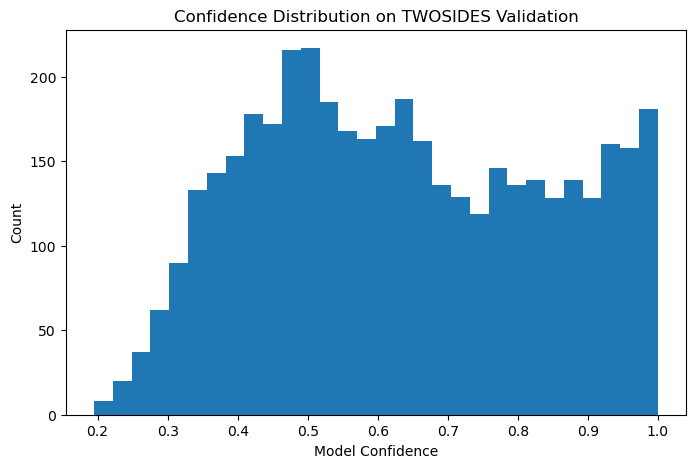

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df["Confidence"], bins=30)
plt.xlabel("Model Confidence")
plt.ylabel("Count")
plt.title("Confidence Distribution on TWOSIDES Validation")
plt.show()


In [57]:
top_cases = df.sort_values("Confidence", ascending=False).head(10)

top_cases[[
    "Drug1", "Drug2", "Condition",
    "PRR", "Freq", "Confidence", "Text"
]]


,Drug1,Drug2,Condition,PRR,Freq,Confidence,Text
1585,Buspirone,Pramipexole,Fall,4.61538,0.098361,0.999848,Buspirone may increase the sedative activities...
1292,Levetiracetam,MAGNESIUM GLUCONATE,Decreased appetite,5.00000,0.066667,0.999712,Levetiracetam may increase the central nervous...
785,Clindamycin,Pramipexole,Intervertebral disc protrusion,20.00000,0.173913,0.999663,Clindamycin may increase the sedative activiti...
1060,Roflumilast,Fenoterol,Weight decreased,6.00000,0.125000,0.999518,Roflumilast may increase the immunosuppressive...
2549,Salicylic Acid,Levofloxacin,Red blood cell count decreased,10.00000,0.071429,0.999516,Salicylic Acid may increase the neuroexcitator...
3054,Naltrexone,Sodium Oxybate,Constipation,10.00000,0.117647,0.999452,Naltrexone may increase the central nervous sy...
462,Propranolol,Mycophenolic Acid,Dehydration,6.66667,0.083333,0.999295,Propranolol may decrease the antihypertensive ...
831,oxaliplatin,Acebutolol,Pulmonary embolism,20.00000,0.125000,0.999140,oxaliplatin may increase the bradycardic activ...
1131,deferasirox,levothyroxine,Pyrexia,5.16483,0.128065,0.998899,The serum concentration of levothyroxine can b...
1477,pamidronate,Atenolol,Hypoaesthesia,12.85710,0.118421,0.998892,pamidronate may increase the bradycardic activ...


In [58]:
hard_cases = df.sort_values("Confidence").head(10)

hard_cases[[
    "Drug1", "Drug2", "Condition",
    "PRR", "Freq", "Confidence", "Text"
]]


,Drug1,Drug2,Condition,PRR,Freq,Confidence,Text
2988,fluticasone,Teicoplanin,Oedema peripheral,3.33333,0.055556,0.194869,The serum concentration of Teicoplanin can be ...
2595,darunavir,Thiamine,Myocardial infarction,20.00000,0.181818,0.196020,The serum concentration of Thiamine can be inc...
1084,Lactulose,Cisapride,Cerebrovascular accident,15.00000,0.111111,0.202193,The risk or severity of adverse effects can be...
2841,Epinephrine,Terazosin,Cardiac disorder,10.00000,0.157895,0.204603,The risk or severity of adverse effects can be...
2977,rabeprazole,trimethobenzamide,Anxiety,15.00000,0.187500,0.209939,The risk or severity of adverse effects can be...
172,deflazacort,Glucosamine,Pain in extremity,20.00000,0.200000,0.215307,deflazacort may increase the respiratory depre...
3373,Tobramycin,Levalbuterol,Staphylococcal infection,35.00000,0.088608,0.216504,Tobramycin may increase the QTc-prolonging act...
3936,colesevelam,Amitriptyline,Urticaria,40.00000,0.080000,0.219965,The serum concentration of Amitriptyline can b...
2117,colesevelam,Gemfibrozil,Fall,3.75000,0.085714,0.222612,The metabolism of Gemfibrozil can be decreased...
108,exemestane,Loratadine,Pyrexia,6.66667,0.086957,0.222722,The metabolism of Loratadine can be increased ...


In [59]:
cond_stats = df.groupby("Condition").agg(
    count=("Confidence", "count"),
    avg_conf=("Confidence", "mean"),
    agree_rate=("Agreement", "mean")
).sort_values("count", ascending=False)

cond_stats.head(10)


,count,avg_conf,agree_rate
Condition,,,
Vomiting,93,0.640264,0.548387
Diarrhoea,87,0.642057,0.471264
Pyrexia,81,0.624160,0.506173
Pneumonia,72,0.638629,0.513889
Dyspnoea,71,0.597515,0.450704
Pain,70,0.641072,0.514286
Asthenia,69,0.630474,0.550725
Fall,67,0.649504,0.507463
Anaemia,64,0.584377,0.453125


In [60]:
summary = {
    "total_rows": len(df),
    "unique_drugs": df["Drug1"].nunique() + df["Drug2"].nunique(),
    "agreement_rate": agreement_rate,
    "avg_confidence": df["Confidence"].mean(),
    "median_confidence": df["Confidence"].median()
}

pd.DataFrame([summary]).to_csv(
    "twosides_validation_summary.csv",
    index=False
)

print("Saved summary → twosides_validation_summary.csv")


Saved summary → twosides_validation_summary.csv
